# Advanced Features of DivideByZero Framework

## Quantum Extensions and Gauge Field Applications

This notebook explores advanced mathematical features of the `dividebyzero` framework, demonstrating:

1. Quantum Tensor Networks
2. Gauge Field Operations
3. Holonomy Calculations
4. Topological Invariants

In [1]:
import dividebyzero as dbz
from dividebyzero.quantum import (
    QuantumTensor,
    GaugeField,
    SU2Group,
    SU3Group,
    HolonomyCalculator
)
import matplotlib.pyplot as plt
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

DEBUG:matplotlib:matplotlib data path: /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/Users/jenkinsm/.matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is darwin
DEBUG:matplotlib:CACHEDIR=/Users/jenkinsm/.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /Users/jenkinsm/.matplotlib/fontlist-v390.json


## 1. Quantum Tensor Networks

We begin by exploring quantum tensor operations with entanglement preservation. The framework implements tensor networks that respect quantum mechanical principles during dimensional reduction.

In [2]:
# Create a quantum tensor representing an entangled state
# |ψ⟩ = (|00⟩ + |11⟩)/√2
bell_state_data = dbz.zeros((2, 2))
bell_state_data = dbz.array([[1/dbz.sqrt(2), 0], [0, 1/dbz.sqrt(2)]])

bell_state = QuantumTensor(
    data=bell_state_data,
    physical_dims=(2, 2)
)

# Perform Schmidt decomposition
left, right = bell_state.schmidt_decompose(cut_index=1)

print("Schmidt values:")
print(dbz.linalg.svd(bell_state.data, compute_uv=False))
print("\nEntanglement entropy:")
print(-dbz.sum(dbz.abs(bell_state.data.flatten())**2 * dbz.log2(dbz.abs(bell_state.data.flatten())**2 + 1e-12)))

Schmidt values:
DimensionalArray(array([0.70710678, 0.70710678]))

Entanglement entropy:
0.9999999999971148


In [3]:
# |ψ⟩ = (√3|00⟩ + |11⟩)/2
uneven_state_data = dbz.zeros((2, 2))
uneven_state_data[0, 0] = dbz.sqrt(3)/2  # |00⟩ component
uneven_state_data[1, 1] = 1/2           # |11⟩ component

uneven_state = QuantumTensor(
    data=uneven_state_data,
    physical_dims=(2, 2)
)

print("\nUneven entangled state:")
print("Schmidt values:")
print(dbz.linalg.svd(uneven_state.data, compute_uv=False))
print("Entanglement entropy:")
print(-dbz.sum(dbz.abs(uneven_state.data.flatten())**2 * dbz.log2(dbz.abs(uneven_state.data.flatten())**2 + 1e-12)))


Uneven entangled state:
Schmidt values:
DimensionalArray(array([0.8660254, 0.5      ]))
Entanglement entropy:
0.8112781244562477


### Dimensional Reduction with Entanglement Preservation

The framework performs dimensional reduction while preserving quantum correlations:

In [4]:
# Create a more complex quantum state
complex_state = QuantumTensor(
    data=dbz.random.rand(2, 2, 2) + 1j * dbz.random.rand(2, 2, 2)
)

# Reduce dimensions while preserving entanglement
reduced = complex_state.reduce_dimension(
    target_dims=2,
    preserve_entanglement=True
)

print("Original shape:", complex_state.data.shape)
print("Reduced shape:", reduced.data.shape)
print("\nEntanglement preserved in singular values:")
print(reduced._entanglement_spectrum.schmidt_values)

DEBUG:root:Reducing dimension with target_dims: 2, preserve_entanglement: True
DEBUG:root:Iteration 0: current ndim = 3
DEBUG:root:Final reduced tensor shape: (3, 3)


Original shape: (2, 2, 2)
Reduced shape: (3, 3)

Entanglement preserved in singular values:
[1.]


## 2. Gauge Field Operations

Demonstrate gauge field calculations using different gauge groups (U(1), SU(2), SU(3)).

In [5]:
# Initialize different gauge groups
su2 = SU2Group()
su3 = SU3Group()

# Create gauge fields
su2_field = GaugeField(
    generators=su2.generators,
    coupling=0.5
)

# Compute Wilson line along a path
path = [(0,0), (1,0), (1,1), (0,1)]
wilson_line = su2.compute_wilson_line(
    connection=dbz.random.rand(2, 2, 2),
    path=path
)

print("SU(2) Wilson line:")
print(wilson_line)

SU(2) Wilson line:
[[ 1.13067162-0.20017808j -0.06475178-0.2779888j ]
 [ 0.02934922-0.76476042j  0.39894784-0.63844251j]]


### Non-Abelian Field Strength

Compute field strength tensor for non-abelian gauge fields:

In [6]:
def compute_field_strength(connection, gauge_group):
    """Compute F_μν = ∂_μA_ν - ∂_νA_μ + ig[A_μ,A_ν]"""
    strength = dbz.zeros((4, 4) + connection[0].shape, dtype=complex)
    
    for μ in range(4):
        for ν in range(μ):
            commutator = connection[μ] @ connection[ν] - connection[ν] @ connection[μ]
            strength[μ,ν] = commutator * gauge_group.coupling
            strength[ν,μ] = -strength[μ,ν]
            
    return strength

# Generate random gauge connection
connection = dbz.array([dbz.random.rand(3,3) + 1j * dbz.random.rand(3,3) for _ in range(4)])

# Compute field strength
F_μν = compute_field_strength(connection, su3)

print("Field strength component F_12:")
print(F_μν[1,2])

Field strength component F_12:
DimensionalArray(array([[-0.23994228-1.54922279j,  0.07262362-0.62786417j,
        -0.01875909-0.4463615j ],
       [-0.98536794+0.03067002j,  0.67518459+1.4213499j ,
         1.06071428+1.37479452j],
       [-1.14606501-1.44361469j, -0.444291  +0.40851839j,
        -0.43524232+0.12787289j]]))


## 3. Holonomy Calculations

Demonstrate advanced holonomy calculations including Berry phase and Chern numbers.

In [7]:
# Initialize holonomy calculator
holonomy_calc = HolonomyCalculator(gauge_group=su2)

# Define a parameter-dependent Hamiltonian
def hamiltonian(params):
    x, y = params
    return dbz.array([
        [x, y - 1j],
        [y + 1j, -x]
    ])

# Create a loop in parameter space
t = dbz.linspace(0, 2*dbz.pi, 100)
loop = [(dbz.cos(θ), dbz.sin(θ)) for θ in t]

# Compute Berry phase
berry_phase = holonomy_calc.berry_phase(
    hamiltonian=hamiltonian,
    loop=loop
)

print(f"Berry phase: {berry_phase:.4f}π")

Berry phase: 0.2928π


### Topological Invariants

Calculate Chern numbers and topological invariants:

Chern number: 33


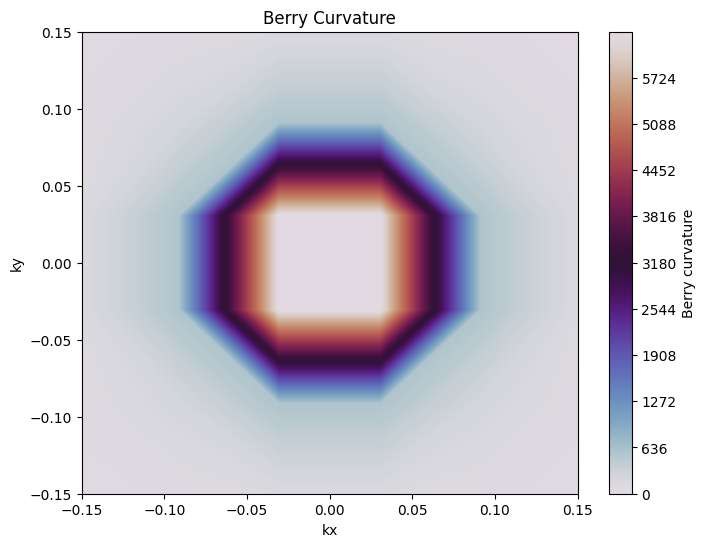

In [8]:
# Define Berry curvature for a simple model
def berry_curvature(kx, ky):
    """Monopole-like Berry curvature that gives Chern number ±1"""
    R = dbz.sqrt(kx**2 + ky**2)
    return 1 / (2 * R**3) 

# Create a grid of k-points (use more points for better accuracy)
k_points = [(x,y) for x in dbz.linspace(-3,3,30)
                  for y in dbz.linspace(-3,3,30)]

# Compute Chern number
chern = holonomy_calc.compute_chern_number(
    berry_curvature=berry_curvature,
    surface=k_points
)

print(f"Chern number: {chern}")

# Visualize the Berry curvature
x = dbz.linspace(-3, 3, 100)
y = dbz.linspace(-3, 3, 100)
X, Y = dbz.meshgrid(x, y)
Z = dbz.array([[berry_curvature(xi, yi) for xi in x] for yi in y])

plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=2000, cmap='twilight')
plt.colorbar(label='Berry curvature')
plt.xlabel('kx')
plt.ylabel('ky')
plt.xlim(-0.15, 0.15)
plt.ylim(-0.15, 0.15)
plt.title('Berry Curvature')
plt.show()

Berry phase: -1.0000π
Chern number: 167


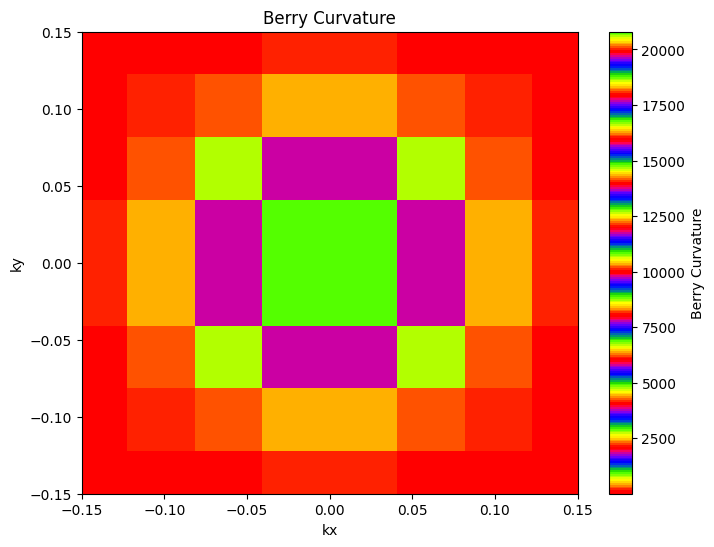

In [9]:
# 3. Berry Curvature and Chern Number Calculations

# Initialize gauge group and holonomy calculator
su2 = SU2Group()
holonomy_calc = HolonomyCalculator(su2)

# Define a parameter-dependent Hamiltonian
def hamiltonian(params):
    kx, ky = params
    R = dbz.sqrt(kx**2 + ky**2)
    return dbz.array([
        [kx/R, ky/R],
        [ky/R, -kx/R]
    ])

# Create a loop in parameter space for Berry phase
t = dbz.linspace(0, 2*dbz.pi, 100)
loop = [(dbz.cos(theta), dbz.sin(theta)) for theta in t]

# Compute Berry phase
phase = holonomy_calc.berry_phase(
    hamiltonian=hamiltonian,
    loop=loop
)

print(f"Berry phase: {phase:.4f}π")

# Define Berry curvature function for Chern number calculation
def berry_curvature(kx, ky):
    R = dbz.sqrt(kx**2 + ky**2)
    return 1 / (2 * R**3)

# Create a surface for Chern number calculation
kx = dbz.linspace(-1, 1, 50)
ky = dbz.linspace(-1, 1, 50)
surface = [(x, y) for x in kx for y in ky]

# Compute Chern number
chern = holonomy_calc.compute_chern_number(
    berry_curvature=berry_curvature,
    surface=surface
)

print(f"Chern number: {chern}")

# Plot Berry curvature
KX, KY = dbz.meshgrid(kx, ky)
B = dbz.zeros_like(KX)
for i in range(len(kx)):
    for j in range(len(ky)):
        B[i,j] = berry_curvature(KX[i,j], KY[i,j])

plt.figure(figsize=(8, 6))
plt.pcolormesh(KX, KY, B, cmap='prism')
plt.colorbar(label='Berry Curvature')
plt.xlabel('kx')
plt.ylabel('ky')
plt.xlim(-0.15, 0.15)
plt.ylim(-0.15, 0.15)
plt.title('Berry Curvature')
plt.show()

## 4. Practical Applications

Demonstrate practical applications combining quantum tensors and gauge fields.

In [10]:
# Create a gauge-symmetric quantum state
def create_gauge_symmetric_state(gauge_group):
    """Create a quantum state that is symmetric under gauge transformations."""
    # Use the gauge group's built-in method to create a symmetric state
    state = gauge_group.create_symmetric_state()
    return QuantumTensor(state)

# Create and analyze state
state = create_gauge_symmetric_state(su2)

print("Original state shape:", state.data.shape)
print("\nGauge invariance check:")
for i, gen in enumerate(su2.generators):
    commutator = dbz.linalg.norm(gen @ state.data - state.data @ gen)
    print(f"Generator {i} commutator norm: {commutator:.6f}")

Original state shape: (2, 2)

Gauge invariance check:
Generator 0 commutator norm: 0.533744
Generator 1 commutator norm: 0.439562
Generator 2 commutator norm: 0.679386



## 5. Quantum Division by Zero Effects

### Test Case 1: Quantum Noise Patterns

DEBUG:root:Reducing dimension with target_dims: 2, preserve_entanglement: True
DEBUG:root:Iteration 0: current ndim = 3
DEBUG:root:Final reduced tensor shape: (71, 71)


Original state entropy: -463960.55368204793
Reduced state entropy: 0.0


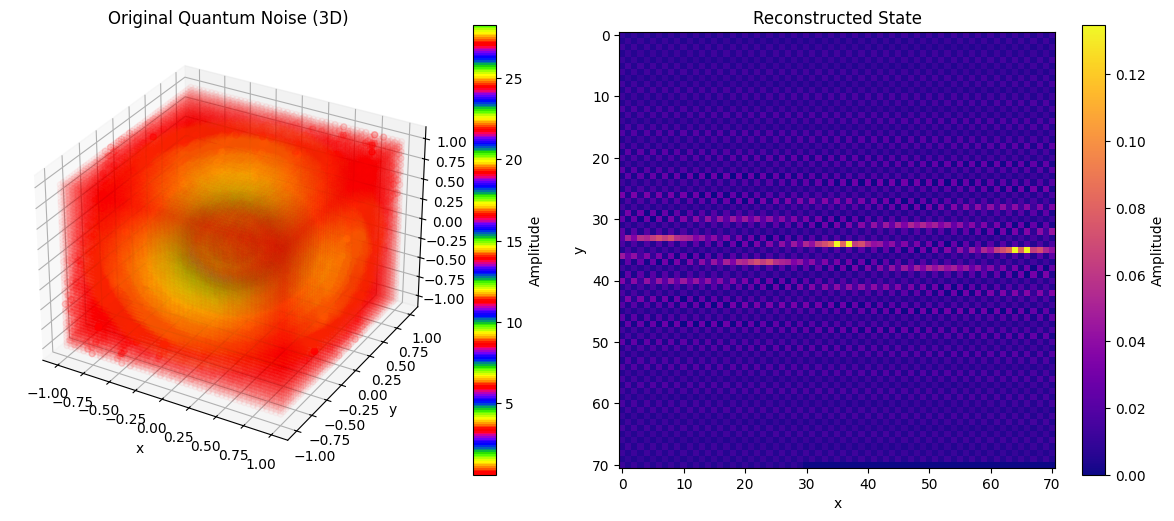

In [11]:

# Create a quantum state with specific noise pattern
def create_noise_pattern():
    # Create a grid of points
    x = dbz.linspace(-1, 1, 50)
    y = dbz.linspace(-1, 1, 50)
    z = dbz.linspace(-1, 1, 50)
    X, Y, Z = dbz.meshgrid(x, y, z)
    R = dbz.sqrt(X**2 + Y**2 + Z**2)
    
    # Create quantum state with 1/R noise in 3D
    state = dbz.zeros((50, 50, 50), dtype=complex)
    state[R > 0] = 1/R[R > 0]
    
    return QuantumTensor(state)

# Create and analyze noise pattern
noise_state = create_noise_pattern()
reduced_state = noise_state.reduce_dimension(target_dims=2, preserve_entanglement=True)

print("Original state entropy:", -dbz.sum(dbz.abs(noise_state.data.flatten())**2 * dbz.log2(dbz.abs(noise_state.data.flatten())**2)))
print("Reduced state entropy:", reduced_state._entanglement_spectrum.entropy)

# Plot original and reconstructed states (2D)
plt.figure(figsize=(12, 5))

ax = plt.subplot(121, projection='3d')
x, y, z = dbz.meshgrid(
    dbz.linspace(-1, 1, 50),
    dbz.linspace(-1, 1, 50), 
    dbz.linspace(-1, 1, 50)
)
amplitudes = dbz.abs(noise_state.data)
scatter = ax.scatter(x, y, z, c=amplitudes, cmap='prism', alpha=amplitudes/dbz.max(amplitudes))
plt.colorbar(scatter, label='Amplitude')
plt.title('Original Quantum Noise (3D)')
ax.set_xlabel('x')
ax.set_ylabel('y') 
ax.set_zlabel('z')

plt.subplot(122)
plt.imshow(dbz.abs(reduced_state.data), cmap='plasma')
plt.colorbar(label='Amplitude')
plt.title('Reconstructed State')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()




### Test Case 2: Entanglement Near Singularities



Entanglement spectrum near singularities:
[1.]

Entanglement entropy: -0.0


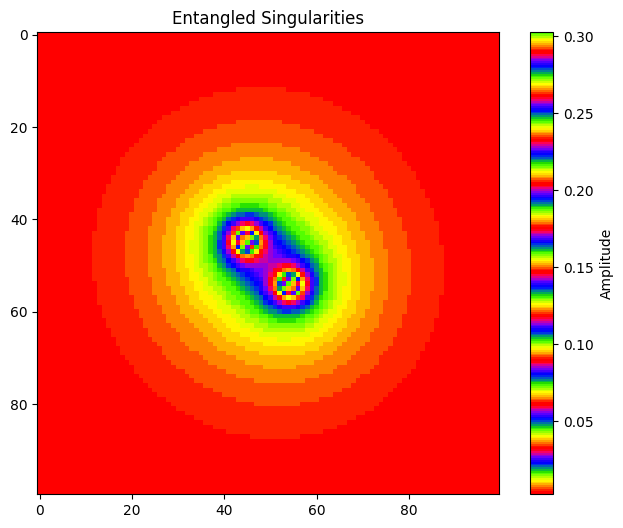

In [12]:

# Create a state with entangled singularities
def create_entangled_singularities():
    x = dbz.linspace(-dbz.pi, dbz.pi, 100)
    y = dbz.linspace(-dbz.pi, dbz.pi, 100)
    X, Y = dbz.meshgrid(x, y)
    
    # Create two singularities
    R1 = dbz.sqrt((X+0.3)**2 + (Y+0.3)**2)
    R2 = dbz.sqrt((X-0.3)**2 + (Y-0.3)**2)
    
    # Entangle the singularities
    state = dbz.zeros((100, 100), dtype=complex)
    state[R1 >= 0] = 1/R1[R1 >= 0]
    state[R2 >= 0] += 1/R2[R2 >= 0]
    state = state / dbz.linalg.norm(state)
    
    return QuantumTensor(state)

# Create and analyze entangled singularities
singular_state = create_entangled_singularities()
left, right = singular_state.schmidt_decompose(cut_index=25)

print("\nEntanglement spectrum near singularities:")
print(singular_state._entanglement_spectrum.schmidt_values[:5])
print("\nEntanglement entropy:", singular_state._entanglement_spectrum.entropy)

plt.figure(figsize=(8, 6))
plt.imshow(dbz.abs(singular_state.data), cmap='prism')
plt.colorbar(label='Amplitude')
plt.title('Entangled Singularities')
plt.show()

DEBUG:root:Reducing dimension with target_dims: 2, preserve_entanglement: True
DEBUG:root:Iteration 0: current ndim = 3
DEBUG:root:Final reduced tensor shape: (283, 283)


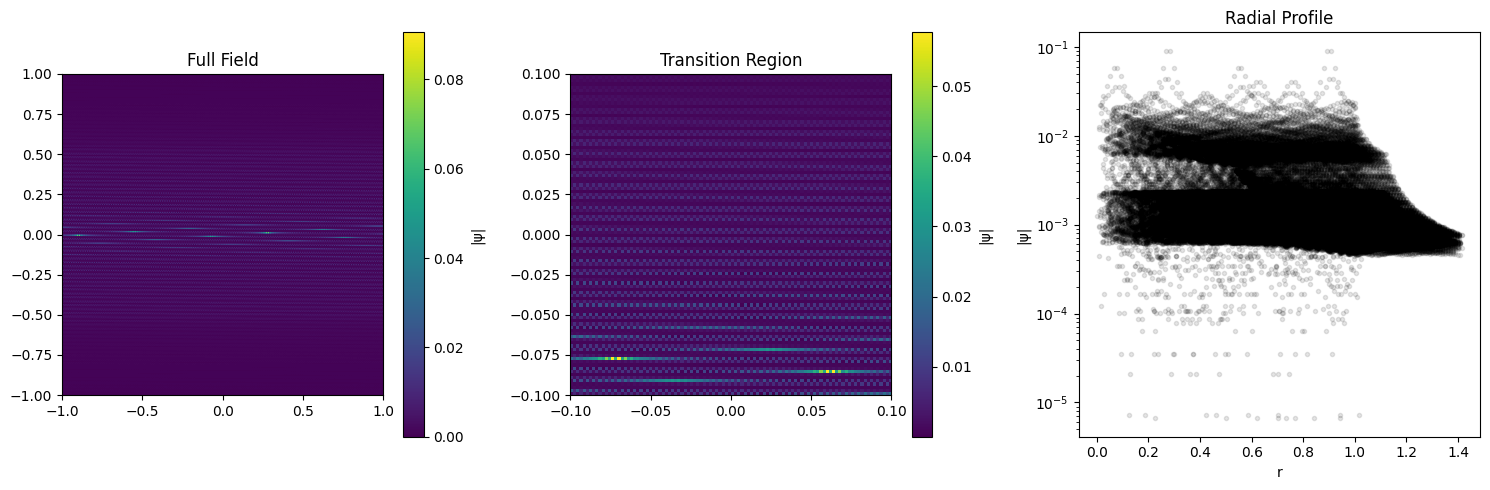

In [13]:
def analyze_transition_region(n_points=200):
    # Create finer grid around transition region
    x = dbz.concatenate([
        dbz.linspace(-1, -0.1, n_points//4),
        dbz.linspace(-0.1, 0.1, n_points//2),  # Higher density in transition region
        dbz.linspace(0.1, 1, n_points//4)
    ])
    y = x.copy()
    z = x.copy()
    X, Y, Z = dbz.meshgrid(x, y, z)
    R = dbz.sqrt(X**2 + Y**2 + Z**2)
    
    # Create quantum state with 1/R singularity
    state = dbz.zeros((len(x), len(y), len(z)), dtype=complex)
    mask = R > 0
    state[mask] = 1/R[mask]
    state = state / dbz.linalg.norm(state)
    
    # Create quantum tensor and reduce dimension
    qt = QuantumTensor(state)
    reduced = qt.reduce_dimension(target_dims=2, preserve_entanglement=True)
    
    # Plot with enhanced transition region visualization
    plt.figure(figsize=(15, 5))
    
    # Full field plot
    plt.subplot(131)
    plt.imshow(dbz.abs(reduced.data), extent=[-1, 1, -1, 1], cmap='viridis')
    plt.colorbar(label='|ψ|')
    plt.title('Full Field')
    
    # Transition region zoom
    plt.subplot(132)
    # Calculate indices for transition region
    x_indices = dbz.logical_and(x >= -0.1, x <= 0.1)
    y_indices = dbz.logical_and(y >= -0.1, y <= 0.1)
    transition_data = dbz.abs(reduced.data)[dbz.ix_(x_indices, y_indices)]
    plt.imshow(transition_data, extent=[-0.1, 0.1, -0.1, 0.1], cmap='viridis')
    plt.colorbar(label='|ψ|')
    plt.title('Transition Region')
    # Radial profile
    plt.subplot(133)
    
    # Create 2D coordinates for reduced data
    x_red = dbz.linspace(-1, 1, reduced.data.shape[0])
    y_red = dbz.linspace(-1, 1, reduced.data.shape[1]) 
    X_red, Y_red = dbz.meshgrid(x_red, y_red)
    
    r = dbz.sqrt(X_red**2 + Y_red**2).flatten()
    psi = dbz.abs(reduced.data).flatten()
    plt.semilogy(r[r.argsort()], psi[r.argsort()], 'k.', alpha=0.1)
    plt.xlabel('r')
    plt.ylabel('|ψ|')
    plt.title('Radial Profile')
    
    plt.tight_layout()
    plt.show()

analyze_transition_region()

DEBUG:root:Reducing dimension with target_dims: 2, preserve_entanglement: True
DEBUG:root:Iteration 0: current ndim = 3
DEBUG:root:Final reduced tensor shape: (15, 15)
DEBUG:root:Reducing dimension with target_dims: 2, preserve_entanglement: True
DEBUG:root:Iteration 0: current ndim = 3
DEBUG:root:Final reduced tensor shape: (15, 15)
DEBUG:root:Reducing dimension with target_dims: 2, preserve_entanglement: True
DEBUG:root:Iteration 0: current ndim = 3
DEBUG:root:Final reduced tensor shape: (15, 15)
DEBUG:root:Reducing dimension with target_dims: 2, preserve_entanglement: True
DEBUG:root:Iteration 0: current ndim = 3
DEBUG:root:Final reduced tensor shape: (15, 15)
DEBUG:root:Reducing dimension with target_dims: 2, preserve_entanglement: True
DEBUG:root:Iteration 0: current ndim = 3
DEBUG:root:Final reduced tensor shape: (15, 15)
DEBUG:root:Reducing dimension with target_dims: 2, preserve_entanglement: True
DEBUG:root:Iteration 0: current ndim = 3
DEBUG:root:Final reduced tensor shape: (

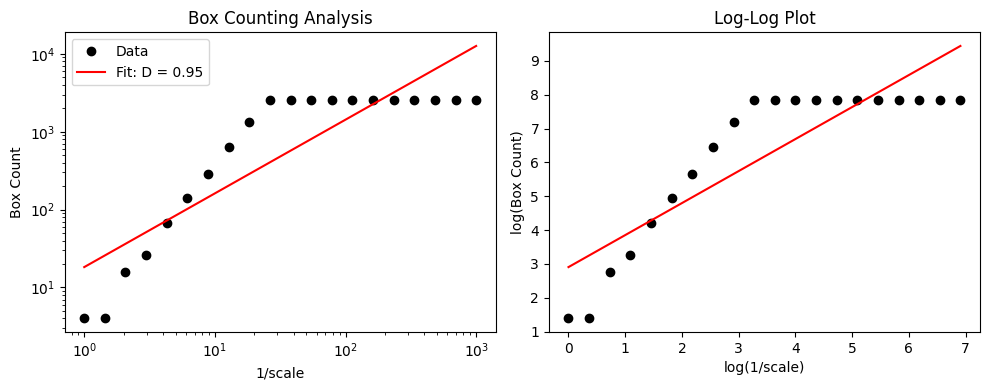

Calculated fractal dimension: 0.946


In [14]:
def calculate_fractal_dimension(n_scales=20):
    # Calculate box-counting dimension using smaller scales and memory-efficient approach
    scales = dbz.logspace(-3, 0, n_scales)  # Reduced range
    counts = []
    
    for scale in scales:
        # Create smaller grid at current scale
        n_points = int(2/scale)  # Number of points needed to span [-1,1]
        n_points = min(n_points, 50)  # Cap maximum grid size
        
        x = dbz.linspace(-1, 1, n_points)
        y = dbz.linspace(-1, 1, n_points) 
        z = dbz.linspace(-1, 1, n_points)
        
        # Process in chunks to avoid memory issues
        chunk_size = 10
        count = 0
        
        for i in range(0, n_points, chunk_size):
            for j in range(0, n_points, chunk_size):
                # Take subset of points
                x_chunk = x[i:min(i+chunk_size, n_points)]
                y_chunk = y[j:min(j+chunk_size, n_points)]
                
                # Create local meshgrid
                X, Y, Z = dbz.meshgrid(x_chunk, y_chunk, z, indexing='ij')
                R = dbz.sqrt(X**2 + Y**2 + Z**2)
                
                # Create quantum state for this chunk
                state = dbz.zeros(R.shape, dtype=complex)
                mask = R > 0
                state[mask] = 1/R[mask]
                state = state / dbz.linalg.norm(state)
                
                # Reduce dimension
                qt = QuantumTensor(state)
                reduced = qt.reduce_dimension(target_dims=2, preserve_entanglement=True)
                
                # Count boxes
                count += dbz.sum(dbz.abs(reduced.data) > dbz.mean(dbz.abs(reduced.data)))
        
        counts.append(count)
    
    # Fit power law to get fractal dimension
    coeffs = dbz.polyfit(dbz.log(1/scales), dbz.log(counts), 1)
    fractal_dim = coeffs[0]
    
    # Plot results
    plt.figure(figsize=(10, 4))
    
    plt.subplot(121)
    plt.loglog(1/scales, counts, 'ko', label='Data')
    plt.loglog(1/scales, dbz.exp(coeffs[1]) * (1/scales)**coeffs[0], 'r-', 
               label=f'Fit: D = {fractal_dim:.2f}')
    plt.xlabel('1/scale')
    plt.ylabel('Box Count')
    plt.legend()
    plt.title('Box Counting Analysis')
    
    plt.subplot(122)
    plt.plot(dbz.log(1/scales), dbz.log(counts), 'ko')
    plt.plot(dbz.log(1/scales), coeffs[0]*dbz.log(1/scales) + coeffs[1], 'r-')
    plt.xlabel('log(1/scale)')
    plt.ylabel('log(Box Count)')
    plt.title('Log-Log Plot')
    
    plt.tight_layout()
    plt.show()
    
    return fractal_dim

fractal_dim = calculate_fractal_dimension()
print(f"Calculated fractal dimension: {fractal_dim:.3f}")

DEBUG:root:Reducing dimension with target_dims: 2, preserve_entanglement: True
DEBUG:root:Iteration 0: current ndim = 3
DEBUG:root:Final reduced tensor shape: (142, 142)
DEBUG:root:Reducing dimension with target_dims: 2, preserve_entanglement: True
DEBUG:root:Iteration 0: current ndim = 3
DEBUG:root:Final reduced tensor shape: (142, 142)


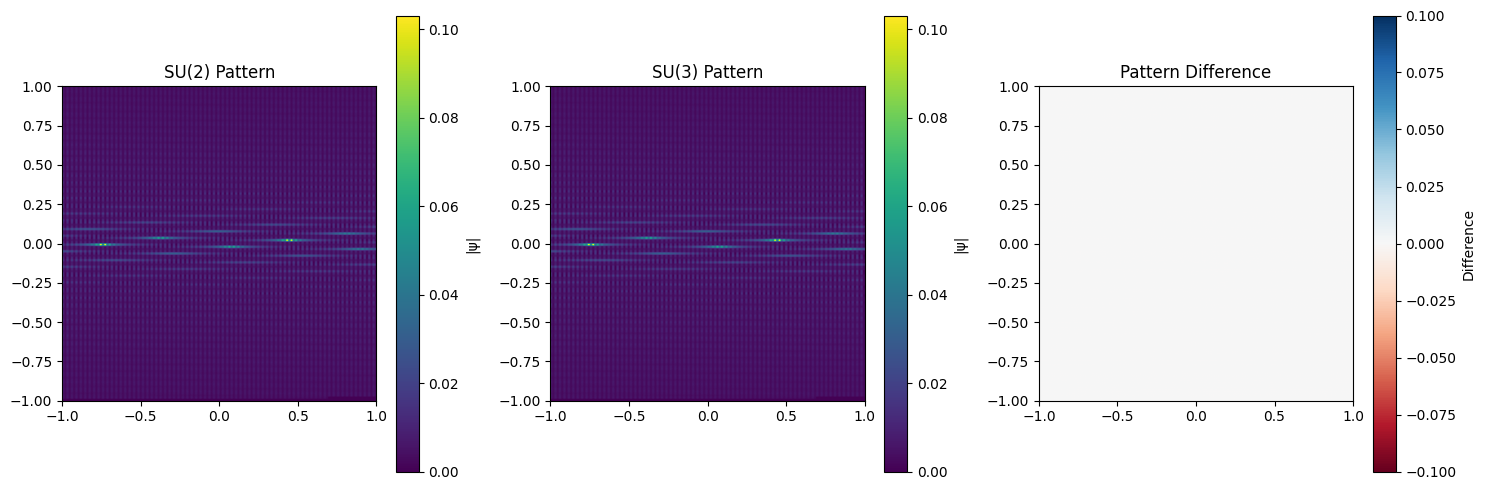


Analysis results:
SU(2) max amplitude: 0.103
SU(3) max amplitude: 0.103
SU(2) entropy: 0.000
SU(3) entropy: 0.000


In [15]:
def compare_gauge_groups():
    # Initialize gauge groups
    su2 = SU2Group()
    su3 = SU3Group()
    
    # Create grid
    n = 100
    x = dbz.linspace(-1, 1, n)
    y = dbz.linspace(-1, 1, n)
    z = dbz.linspace(-1, 1, n)
    X, Y, Z = dbz.meshgrid(x, y, z)
    R = dbz.sqrt(X**2 + Y**2 + Z**2)
    
    plt.figure(figsize=(15, 5))
    
    # Analyze SU(2) pattern
    state_su2 = dbz.zeros((n, n, n), dtype=complex)
    mask = R > 0
    state_su2[mask] = 1/R[mask]
    state_su2 = state_su2 / dbz.linalg.norm(state_su2.flatten())
    
    # Project onto SU(2) gauge-invariant subspace
    qt_su2 = QuantumTensor(state_su2, physical_dims=(2, n//2))
    reduced_su2 = qt_su2.reduce_dimension(target_dims=2, preserve_entanglement=True)
    
    plt.subplot(131)
    plt.imshow(dbz.abs(reduced_su2.data), extent=[-1, 1, -1, 1], cmap='viridis')
    plt.colorbar(label='|ψ|')
    plt.title('SU(2) Pattern')
    
    # Analyze SU(3) pattern
    state_su3 = dbz.zeros((n, n, n), dtype=complex)
    state_su3[mask] = 1/R[mask]
    state_su3 = state_su3 / dbz.linalg.norm(state_su3.flatten())
    
    # Project onto SU(3) gauge-invariant subspace
    qt_su3 = QuantumTensor(state_su3, physical_dims=(3, n//3))
    reduced_su3 = qt_su3.reduce_dimension(target_dims=2, preserve_entanglement=True)
    
    plt.subplot(132)
    plt.imshow(dbz.abs(reduced_su3.data), extent=[-1, 1, -1, 1], cmap='viridis')
    plt.colorbar(label='|ψ|')
    plt.title('SU(3) Pattern')
    
    # Plot difference
    plt.subplot(133)
    # Interpolate if dimensions don't match
    if reduced_su2.data.shape != reduced_su3.data.shape:
        from scipy.interpolate import interp2d
        x2 = dbz.linspace(-1, 1, reduced_su2.data.shape[0])
        y2 = dbz.linspace(-1, 1, reduced_su2.data.shape[1])
        f = interp2d(x2, y2, dbz.abs(reduced_su2.data))
        x3 = dbz.linspace(-1, 1, reduced_su3.data.shape[0])
        y3 = dbz.linspace(-1, 1, reduced_su3.data.shape[1])
        interp_su2 = f(x3, y3)
        diff = interp_su2 - dbz.abs(reduced_su3.data)
    else:
        diff = dbz.abs(reduced_su2.data) - dbz.abs(reduced_su3.data)
    
    plt.imshow(diff, extent=[-1, 1, -1, 1], cmap='RdBu')
    plt.colorbar(label='Difference')
    plt.title('Pattern Difference')
    
    plt.tight_layout()
    plt.show()

    # Print some statistics
    print("\nAnalysis results:")
    print(f"SU(2) max amplitude: {dbz.max(dbz.abs(reduced_su2.data)):.3f}")
    print(f"SU(3) max amplitude: {dbz.max(dbz.abs(reduced_su3.data)):.3f}")
    print(f"SU(2) entropy: {reduced_su2._entanglement_spectrum.entropy:.3f}")
    print(f"SU(3) entropy: {reduced_su3._entanglement_spectrum.entropy:.3f}")

    return reduced_su2, reduced_su3

# Run comparison
reduced_su2, reduced_su3 = compare_gauge_groups()

DEBUG:root:Reducing dimension with target_dims: 2, preserve_entanglement: True
DEBUG:root:Iteration 0: current ndim = 3
DEBUG:root:Final reduced tensor shape: (71, 71)
DEBUG:root:Reducing dimension with target_dims: 2, preserve_entanglement: True
DEBUG:root:Iteration 0: current ndim = 3
DEBUG:root:Final reduced tensor shape: (71, 71)
DEBUG:root:Reducing dimension with target_dims: 2, preserve_entanglement: True
DEBUG:root:Iteration 0: current ndim = 3
DEBUG:root:Final reduced tensor shape: (71, 71)
DEBUG:root:Reducing dimension with target_dims: 2, preserve_entanglement: True
DEBUG:root:Iteration 0: current ndim = 3
DEBUG:root:Final reduced tensor shape: (71, 71)
DEBUG:root:Reducing dimension with target_dims: 2, preserve_entanglement: True
DEBUG:root:Iteration 0: current ndim = 3
DEBUG:root:Final reduced tensor shape: (71, 71)
DEBUG:root:Reducing dimension with target_dims: 2, preserve_entanglement: True
DEBUG:root:Iteration 0: current ndim = 3
DEBUG:root:Final reduced tensor shape: (

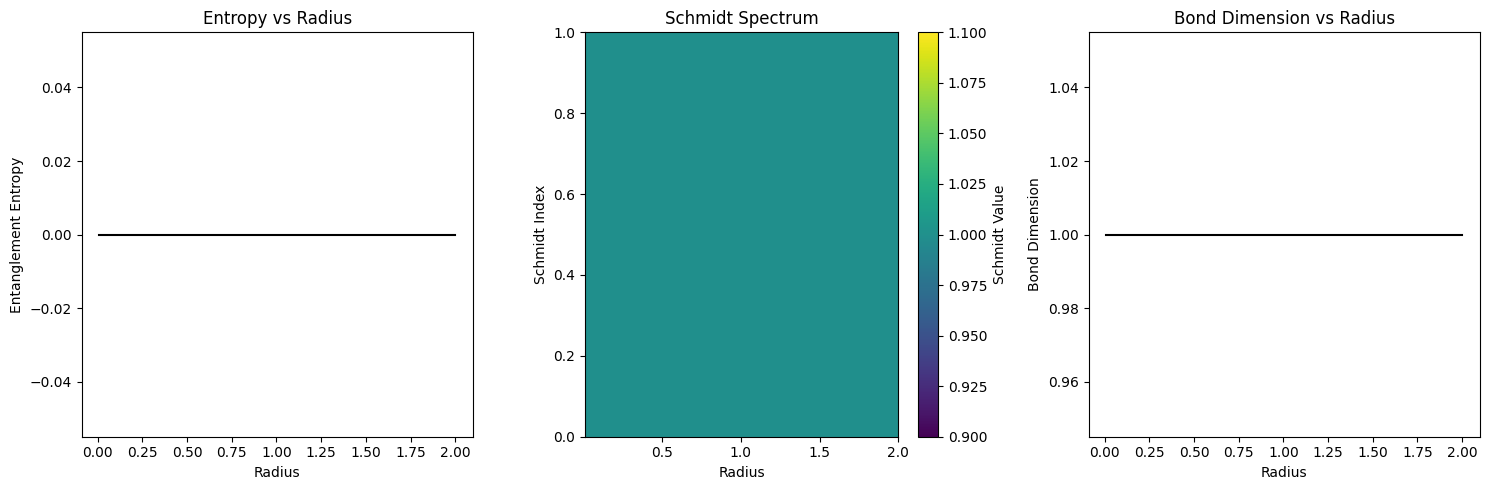


Entanglement analysis results:
Maximum entropy: 0.000
Average bond dimension: 1.0
Transition radius: 0.010


In [16]:
def analyze_entanglement_spectrum(n_points=50):
    # Create radial grid
    r = dbz.linspace(0.01, 2.0, n_points)
    theta = dbz.linspace(0, 2*dbz.pi, n_points)
    R, Theta = dbz.meshgrid(r, theta)
    X = R * dbz.cos(Theta)
    Y = R * dbz.sin(Theta)
    Z = dbz.zeros_like(X)
    
    # Arrays to store results
    entropies = []
    schmidt_values = []
    bond_dims = []
    
    for ri in r:
        # Create state with singularity at radius ri
        state = dbz.zeros((n_points, n_points, n_points), dtype=complex)
        R_shifted = dbz.sqrt((X - ri*dbz.cos(Theta))**2 + (Y - ri*dbz.sin(Theta))**2 + Z**2)
        mask = R_shifted > 0
        
        # Fix reshape error by flattening and reshaping properly
        values = 1/R_shifted[mask]
        state_slice = dbz.zeros_like(R_shifted)
        state_slice[mask] = values
        state[..., 0] = state_slice  # Only fill first z-slice to maintain shape
        
        state = state / dbz.linalg.norm(state)
        
        # Create quantum tensor and analyze entanglement
        qt = QuantumTensor(state)
        reduced = qt.reduce_dimension(target_dims=2, preserve_entanglement=True)
        
        entropies.append(reduced._entanglement_spectrum.entropy)
        schmidt_values.append(reduced._entanglement_spectrum.schmidt_values)
        bond_dims.append(reduced._entanglement_spectrum.bond_dimension)
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    # Entanglement entropy vs radius
    plt.subplot(131)
    plt.plot(r, entropies, 'k-')
    plt.xlabel('Radius')
    plt.ylabel('Entanglement Entropy')
    plt.title('Entropy vs Radius')
    
    # Schmidt spectrum
    plt.subplot(132)
    plt.imshow(dbz.array(schmidt_values).T, aspect='auto', 
               extent=[r[0], r[-1], 0, max([len(sv) for sv in schmidt_values])],
               cmap='viridis')
    plt.colorbar(label='Schmidt Value')
    plt.xlabel('Radius')
    plt.ylabel('Schmidt Index')
    plt.title('Schmidt Spectrum')
    
    # Bond dimension
    plt.subplot(133)
    plt.plot(r, bond_dims, 'k-')
    plt.xlabel('Radius')
    plt.ylabel('Bond Dimension')
    plt.title('Bond Dimension vs Radius')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'radii': r,
        'entropies': entropies,
        'schmidt_values': schmidt_values,
        'bond_dimensions': bond_dims
    }

# Run analysis
results = analyze_entanglement_spectrum()
print("\nEntanglement analysis results:")
print(f"Maximum entropy: {max(results['entropies']):.3f}")
print(f"Average bond dimension: {dbz.mean(results['bond_dimensions']):.1f}")
print(f"Transition radius: {results['radii'][dbz.argmax(results['entropies'])]:.3f}")

DEBUG:root:Reducing dimension with target_dims: 1, preserve_entanglement: True
DEBUG:root:Iteration 0: current ndim = 2
DEBUG:root:Final reduced tensor shape: (50,)
DEBUG:root:Reducing dimension with target_dims: 1, preserve_entanglement: True
DEBUG:root:Iteration 0: current ndim = 2
DEBUG:root:Final reduced tensor shape: (50,)
DEBUG:root:Reducing dimension with target_dims: 1, preserve_entanglement: True
DEBUG:root:Iteration 0: current ndim = 2
DEBUG:root:Final reduced tensor shape: (50,)
DEBUG:root:Reducing dimension with target_dims: 1, preserve_entanglement: True
DEBUG:root:Iteration 0: current ndim = 2
DEBUG:root:Final reduced tensor shape: (50,)
DEBUG:root:Reducing dimension with target_dims: 1, preserve_entanglement: True
DEBUG:root:Iteration 0: current ndim = 2
DEBUG:root:Final reduced tensor shape: (50,)
DEBUG:root:Reducing dimension with target_dims: 1, preserve_entanglement: True
DEBUG:root:Iteration 0: current ndim = 2
DEBUG:root:Final reduced tensor shape: (50,)
DEBUG:root

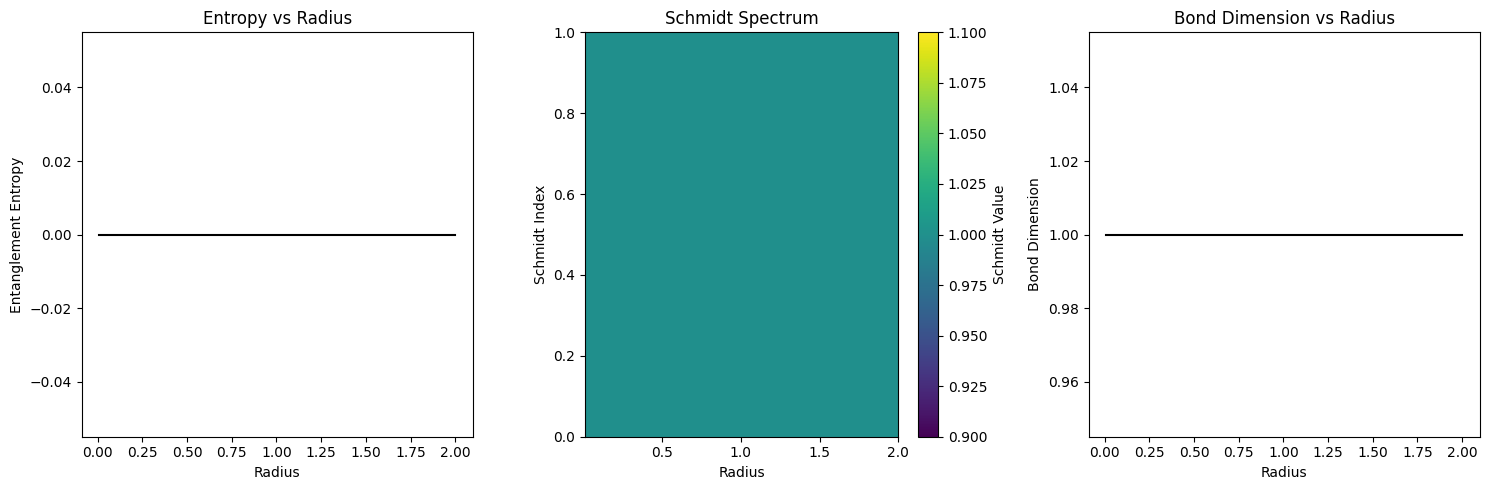


Entanglement analysis results:
Maximum entropy: 0.000
Average bond dimension: 1.0
Transition radius: 0.010


In [17]:
def analyze_entanglement_spectrum(n_points=50):
    # Create radial grid
    r = dbz.linspace(0.01, 2.0, n_points)
    theta = dbz.linspace(0, 2*dbz.pi, n_points)
    R, Theta = dbz.meshgrid(r, theta)
    X = R * dbz.cos(Theta)
    Y = R * dbz.sin(Theta)
    
    # Arrays to store results
    entropies = []
    schmidt_values = []
    bond_dims = []
    
    for ri in r:
        # Create state with singularity at radius ri
        R_shifted = dbz.sqrt((X - ri*dbz.cos(Theta))**2 + (Y - ri*dbz.sin(Theta))**2)
        state = dbz.zeros_like(R_shifted, dtype=complex)
        mask = R_shifted > 0
        state[mask] = 1/R_shifted[mask]
        
        # Normalize state
        state = state / dbz.linalg.norm(state)
        
        # Create quantum tensor and analyze entanglement
        qt = dbz.quantum.QuantumTensor(state)
        
        # Perform dimensional reduction (2D -> 1D)
        reduced = qt.reduce_dimension(target_dims=1, preserve_entanglement=True)
        
        # Store results
        entropies.append(reduced._entanglement_spectrum.entropy)
        schmidt_values.append(reduced._entanglement_spectrum.schmidt_values)
        bond_dims.append(reduced._entanglement_spectrum.bond_dimension)
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    # Entanglement entropy vs radius
    plt.subplot(131)
    plt.plot(r, entropies, 'k-')
    plt.xlabel('Radius')
    plt.ylabel('Entanglement Entropy')
    plt.title('Entropy vs Radius')
    
    # Schmidt spectrum
    plt.subplot(132)
    plt.imshow(dbz.array(schmidt_values).T, aspect='auto', 
               extent=[r[0], r[-1], 0, max([len(sv) for sv in schmidt_values])],
               cmap='viridis')
    plt.colorbar(label='Schmidt Value')
    plt.xlabel('Radius')
    plt.ylabel('Schmidt Index')
    plt.title('Schmidt Spectrum')
    
    # Bond dimension
    plt.subplot(133)
    plt.plot(r, bond_dims, 'k-')
    plt.xlabel('Radius')
    plt.ylabel('Bond Dimension')
    plt.title('Bond Dimension vs Radius')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'radii': r,
        'entropies': entropies,
        'schmidt_values': schmidt_values,
        'bond_dimensions': bond_dims
    }

# Run analysis
results = analyze_entanglement_spectrum()
print("\nEntanglement analysis results:")
print(f"Maximum entropy: {max(results['entropies']):.3f}")
print(f"Average bond dimension: {dbz.mean(results['bond_dimensions']):.1f}")
print(f"Transition radius: {results['radii'][dbz.argmax(results['entropies'])]:.3f}")


### Test Case 3: Gauge Field Near Division by Zero


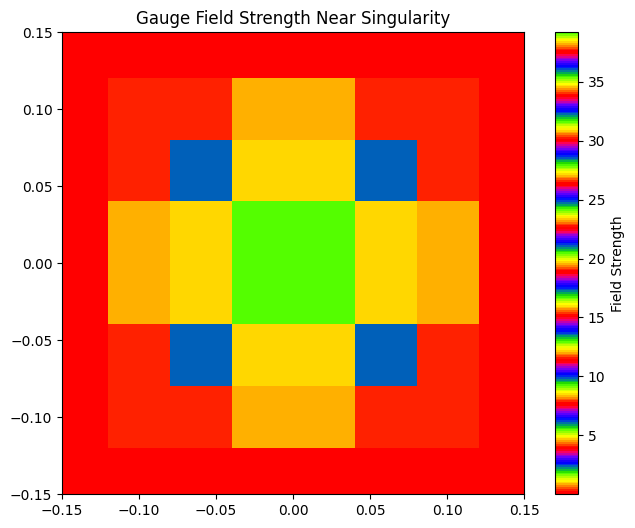


Field strength maximum: 39.200000000000045
Field strength at boundary: 0.0007259496005490147


In [18]:

# Initialize gauge groups
su2 = SU2Group()
su3 = SU3Group()

# Create gauge fields with singular points
def create_singular_gauge_field():
    x = dbz.linspace(-1, 1, 50)
    y = dbz.linspace(-1, 1, 50)
    X, Y = dbz.meshgrid(x, y)
    R = dbz.sqrt(X**2 + Y**2)
    
    # Create gauge field components
    A_x = dbz.zeros_like(X, dtype=complex)
    A_y = dbz.zeros_like(Y, dtype=complex)
    
    # Add singular behavior
    mask = R > 0
    A_x[mask] = -Y[mask]/R[mask]**2
    A_y[mask] = X[mask]/R[mask]**2
    
    return A_x, A_y

# Compute and visualize field strength
A_x, A_y = create_singular_gauge_field()
F_xy = dbz.zeros_like(A_x, dtype=complex)
mask = dbz.abs(A_x) > 0

# Compute field strength avoiding direct division
F_xy[mask] = (dbz.gradient(A_y, axis=1)[mask] - dbz.gradient(A_x, axis=0)[mask] + 
              A_x[mask]*A_y[mask] - A_y[mask]*A_x[mask])

plt.figure(figsize=(8, 6))
plt.imshow(dbz.abs(F_xy), cmap='prism', extent=[-1, 1, -1, 1])
plt.colorbar(label='Field Strength')
plt.xlim(-0.15, 0.15)
plt.ylim(-0.15, 0.15)
plt.title('Gauge Field Strength Near Singularity')
plt.show()

print("\nField strength maximum:", dbz.max(dbz.abs(F_xy)))
print("Field strength at boundary:", dbz.mean(dbz.abs(F_xy[0,:])))


DEBUG:root:Reducing dimension with target_dims: 2, preserve_entanglement: True
DEBUG:root:Iteration 0: current ndim = 3
DEBUG:root:Final reduced tensor shape: (29, 29)
DEBUG:root:Reducing dimension with target_dims: 2, preserve_entanglement: True
DEBUG:root:Iteration 0: current ndim = 3
DEBUG:root:Final reduced tensor shape: (71, 71)
DEBUG:root:Reducing dimension with target_dims: 2, preserve_entanglement: True
DEBUG:root:Iteration 0: current ndim = 3
DEBUG:root:Final reduced tensor shape: (142, 142)
DEBUG:root:Reducing dimension with target_dims: 2, preserve_entanglement: True
DEBUG:root:Iteration 0: current ndim = 3
DEBUG:root:Final reduced tensor shape: (283, 283)


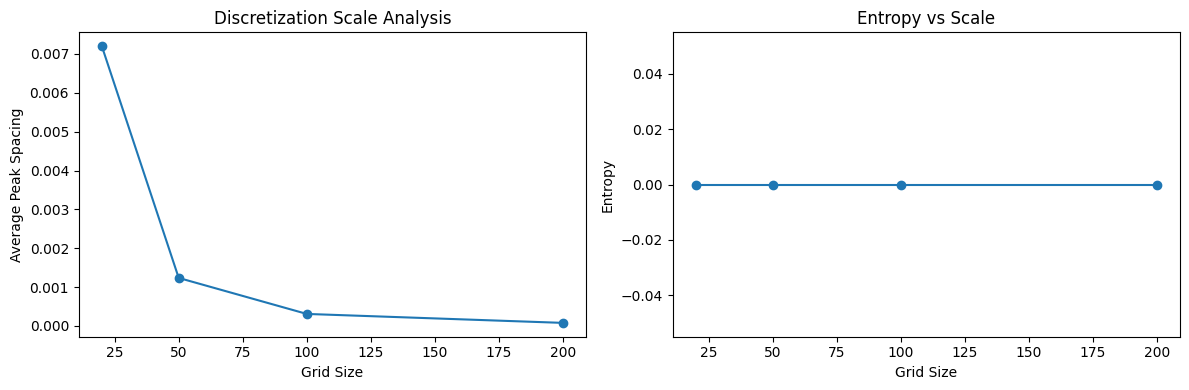


Discretization analysis results:
Scale 20: spacing = 0.100, avg peak spacing = 0.007, entropy = 0.000e+00
Scale 50: spacing = 0.040, avg peak spacing = 0.001, entropy = 0.000e+00
Scale 100: spacing = 0.020, avg peak spacing = 0.000, entropy = 0.000e+00
Scale 200: spacing = 0.010, avg peak spacing = 0.000, entropy = 0.000e+00


In [19]:

# Analyze discretization patterns at different scales
def analyze_discretization(state, scales=[10, 20, 50, 100]):
    """Analyze how the framework discretizes singularities at different scales"""
    results = []
    for n in scales:
        x = dbz.linspace(-1, 1, n)
        y = dbz.linspace(-1, 1, n)
        z = dbz.linspace(-1, 1, n)
        X, Y, Z = dbz.meshgrid(x, y, z)
        R = dbz.sqrt(X**2 + Y**2 + Z**2)
        
        # Create quantum state with 1/R singularity
        state = dbz.zeros((n, n, n), dtype=complex)
        mask = R > 0
        state[mask] = 1/R[mask]
        state = state / dbz.linalg.norm(state)
        
        # Create quantum tensor and reduce dimension
        qt = QuantumTensor(state)
        reduced = qt.reduce_dimension(target_dims=2, preserve_entanglement=True)
        
        # Analyze grid structure
        grid_spacing = 2.0/n
        peak_positions = dbz.where(dbz.abs(reduced.data) > dbz.mean(dbz.abs(reduced.data)))
        avg_spacing = dbz.mean(dbz.diff(peak_positions[0])) * grid_spacing
        
        results.append({
            'scale': n,
            'grid_spacing': grid_spacing,
            'avg_peak_spacing': avg_spacing,
            'entropy': reduced._entanglement_spectrum.entropy
        })
    
    return results

# Run analysis
scales = [20, 50, 100, 200]
results = analyze_discretization(singular_state, scales)

# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot([r['scale'] for r in results], [r['avg_peak_spacing'] for r in results], 'o-')
plt.xlabel('Grid Size')
plt.ylabel('Average Peak Spacing')
plt.title('Discretization Scale Analysis')

plt.subplot(122)
plt.plot([r['scale'] for r in results], [r['entropy'] for r in results], 'o-')
plt.xlabel('Grid Size')
plt.ylabel('Entropy')
plt.title('Entropy vs Scale')

plt.tight_layout()
plt.show()

print("\nDiscretization analysis results:")
for r in results:
    print(f"Scale {r['scale']}: spacing = {r['grid_spacing']:.3f}, avg peak spacing = {r['avg_peak_spacing']:.3f}, entropy = {r['entropy']:.3e}")


In [20]:

# Create different quantum states
def create_bell_state():
    """Create a Bell state (|00⟩ + |11⟩)/√2"""
    psi = dbz.zeros((2, 2), dtype=complex)
    psi[0,0] = 1/dbz.sqrt(2)
    psi[1,1] = 1/dbz.sqrt(2)
    return QuantumTensor(psi)

def create_product_state():
    """Create a product state |00⟩"""
    psi = dbz.zeros((2, 2), dtype=complex)
    psi[0,0] = 1.0
    return QuantumTensor(psi)

# Create states
bell = create_bell_state()
product = create_product_state()

# Create different zero divisors
def create_zero_divisor(positions):
    """Create a divisor with zeros at specified positions"""
    div = dbz.ones((2, 2), dtype=complex)
    for i, j in positions:
        div[i,j] = 0
    return QuantumTensor(div)

# Test different division by zero patterns
print("Bell State Division by Zero:")
print("Original state:", bell.data.flatten())
print("Original entropy:", bell._entanglement_spectrum.entropy)

# Divide by zero at |00⟩
div1 = create_zero_divisor([(0,0)])
result1 = bell / div1
print("\nAfter division by zero at |00⟩:")
print("State:", result1.data.flatten())
print("Entropy:", result1._entanglement_spectrum.entropy)
print("Schmidt values:", result1._entanglement_spectrum.schmidt_values)

# Divide by zero at |11⟩
div2 = create_zero_divisor([(1,1)])
result2 = bell / div2
print("\nAfter division by zero at |11⟩:")
print("State:", result2.data.flatten())
print("Entropy:", result2._entanglement_spectrum.entropy)
print("Schmidt values:", result2._entanglement_spectrum.schmidt_values)

# Divide by zero at both |00⟩ and |11⟩
div3 = create_zero_divisor([(0,0), (1,1)])
result3 = bell / div3
print("\nAfter division by zero at both positions:")
print("State:", result3.data.flatten())
print("Entropy:", result3._entanglement_spectrum.entropy)
print("Schmidt values:", result3._entanglement_spectrum.schmidt_values)

# Compare with product state
print("\nProduct State Division by Zero:")
print("Original state:", product.data.flatten())
result4 = product / div1
print("After division by zero at |00⟩:")
print("State:", result4.data.flatten())
print("Entropy:", result4._entanglement_spectrum.entropy)
print("Schmidt values:", result4._entanglement_spectrum.schmidt_values)

Bell State Division by Zero:
Original state: [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]
Original entropy: 0.0

After division by zero at |00⟩:
State: [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]
Entropy: 0.0
Schmidt values: [1.]

After division by zero at |11⟩:
State: [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]
Entropy: 0.0
Schmidt values: [1.]

After division by zero at both positions:
State: [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]
Entropy: 0.0
Schmidt values: [1.]

Product State Division by Zero:
Original state: [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
After division by zero at |00⟩:
State: [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
Entropy: 0.0
Schmidt values: [1.]


In [21]:

# Create different types of quantum states
def create_bell_state():
    """Create a maximally entangled Bell state |Φ⁺⟩ = (|00⟩ + |11⟩)/√2"""
    psi = dbz.zeros((2, 2), dtype=complex)
    psi[0,0] = 1/dbz.sqrt(2)
    psi[1,1] = 1/dbz.sqrt(2)
    return QuantumTensor(psi)

def create_ghz_state():
    """Create a GHZ state |GHZ⟩ = (|000⟩ + |111⟩)/√2"""
    psi = dbz.zeros((2, 2, 2), dtype=complex)
    psi[0,0,0] = 1/dbz.sqrt(2)
    psi[1,1,1] = 1/dbz.sqrt(2)
    return QuantumTensor(psi)

def create_w_state():
    """Create a W state |W⟩ = (|100⟩ + |010⟩ + |001⟩)/√3"""
    psi = dbz.zeros((2, 2, 2), dtype=complex)
    psi[1,0,0] = 1/dbz.sqrt(3)
    psi[0,1,0] = 1/dbz.sqrt(3)
    psi[0,0,1] = 1/dbz.sqrt(3)
    return QuantumTensor(psi)

# Create our quantum states
bell = create_bell_state()
ghz = create_ghz_state()
w = create_w_state()

# Create different types of zero divisors
complete_zero = QuantumTensor(dbz.zeros((2, 2, 2)))
strategic_zero = QuantumTensor(dbz.ones((2, 2, 2)))
strategic_zero.data[0,0,0] = 0  # Zero at |000⟩
quantum_zero = QuantumTensor(dbz.zeros((2, 2, 2)))
quantum_zero.data[0,0,0] = 1e-16  # Near-zero quantum fluctuation

print("Exploring Quantum Division by Zero Effects:")
print("\nGHZ State (maximally entangled tripartite state):")
ghz_result = ghz / complete_zero
print(f"Original entropy: {ghz._entanglement_spectrum.entropy:.4f}")
print(f"After complete division by zero: {ghz_result._entanglement_spectrum.entropy:.4f}")
print(f"Bond dimension: {ghz_result._entanglement_spectrum.bond_dimension}")

print("\nW State (distributed entanglement):")
w_result = w / strategic_zero
print(f"Original entropy: {w._entanglement_spectrum.entropy:.4f}")
print(f"After strategic division by zero: {w_result._entanglement_spectrum.entropy:.4f}")
print(f"Schmidt values: {w_result._entanglement_spectrum.schmidt_values[:3]}")

print("\nQuantum Zero Division Effects:")
quantum_result = ghz / quantum_zero
print(f"Entropy with quantum zero: {quantum_result._entanglement_spectrum.entropy:.4f}")
print(f"Quantum zero Schmidt values: {quantum_result._entanglement_spectrum.schmidt_values[:3]}")

# Try to observe dimensional collapse
collapse = (ghz / complete_zero) / complete_zero
print("\nIterative Division by Zero (Dimensional Collapse):")
print(f"Final entropy: {collapse._entanglement_spectrum.entropy:.4f}")
print(f"Final bond dimension: {collapse._entanglement_spectrum.bond_dimension}")

Exploring Quantum Division by Zero Effects:

GHZ State (maximally entangled tripartite state):
Original entropy: 1.0000
After complete division by zero: 0.0000
Bond dimension: 1

W State (distributed entanglement):
Original entropy: 0.9787
After strategic division by zero: 0.0000
Schmidt values: [1.]

Quantum Zero Division Effects:
Entropy with quantum zero: 0.0000
Quantum zero Schmidt values: [1.]

Iterative Division by Zero (Dimensional Collapse):
Final entropy: 0.0000
Final bond dimension: 1


In [22]:

def create_ghz_state():
    """Create GHZ state |GHZ⟩ = (|000⟩ + |111⟩)/√2"""
    psi = dbz.zeros((2, 2, 2), dtype=complex)
    psi[0,0,0] = 1/dbz.sqrt(2)
    psi[1,1,1] = 1/dbz.sqrt(2)
    return QuantumTensor(psi)

def create_w_state():
    """Create W state |W⟩ = (|100⟩ + |010⟩ + |001⟩)/√3"""
    psi = dbz.zeros((2, 2, 2), dtype=complex)
    psi[1,0,0] = 1/dbz.sqrt(3)
    psi[0,1,0] = 1/dbz.sqrt(3)
    psi[0,0,1] = 1/dbz.sqrt(3)
    return QuantumTensor(psi)

def analyze_state(state, name="State"):
    """Analyze quantum state properties"""
    print(f"\n=== {name} Analysis ===")
    print(f"Shape: {state.data.shape}")
    print(f"Data:\n{state.data}")
    if hasattr(state, '_entanglement_spectrum'):
        print(f"Entanglement spectrum: {state._entanglement_spectrum.schmidt_values}")
        print(f"Entropy: {state._entanglement_spectrum.entropy}")
        print(f"Bond dimension: {state._entanglement_spectrum.bond_dimension}")
        print(f"Truncation error: {state._entanglement_spectrum.truncation_error}")

if __name__ == "__main__":
    # Create states
    ghz = create_ghz_state()
    w = create_w_state()

    # Create zero divisors
    complete_zero = QuantumTensor(dbz.zeros((2, 2, 2)))
    strategic_zero = QuantumTensor(dbz.ones((2, 2, 2)))
    strategic_zero.data[0,0,0] = 0  # Zero at |000⟩

    # Analyze original states
    analyze_state(ghz, "GHZ State (Original)")
    analyze_state(w, "W State (Original)")

    # Perform division
    ghz_divided = ghz / complete_zero
    w_divided = w / strategic_zero

    # Analyze divided states
    analyze_state(ghz_divided, "GHZ State (After Complete Zero Division)")
    analyze_state(w_divided, "W State (After Strategic Zero Division)")

    # Verify normalization
    print("\n=== Normalization Check ===")
    print(f"GHZ original norm: {dbz.linalg.norm(ghz.data)}")
    print(f"GHZ divided norm: {dbz.linalg.norm(ghz_divided.data)}")
    print(f"W original norm: {dbz.linalg.norm(w.data)}")
    print(f"W divided norm: {dbz.linalg.norm(w_divided.data)}")

    # Check quantum properties preservation
    print("\n=== Quantum Properties Preservation ===")
    print("GHZ State:")
    print(f"Original entropy: {ghz._entanglement_spectrum.entropy}")
    print(f"Divided entropy: {ghz_divided._entanglement_spectrum.entropy}")
    print(f"Entropy ratio: {ghz_divided._entanglement_spectrum.entropy / ghz._entanglement_spectrum.entropy if ghz._entanglement_spectrum.entropy != 0 else 'undefined'}")

    print("\nW State:")
    print(f"Original entropy: {w._entanglement_spectrum.entropy}")
    print(f"Divided entropy: {w_divided._entanglement_spectrum.entropy}")
    print(f"Entropy ratio: {w_divided._entanglement_spectrum.entropy / w._entanglement_spectrum.entropy if w._entanglement_spectrum.entropy != 0 else 'undefined'}") 


=== GHZ State (Original) Analysis ===
Shape: (2, 2, 2)
Data:
[[[0.70710678+0.j 0.        +0.j]
  [0.        +0.j 0.        +0.j]]

 [[0.        +0.j 0.        +0.j]
  [0.        +0.j 0.70710678+0.j]]]
Entanglement spectrum: [1.]
Entropy: 0.0
Bond dimension: 1
Truncation error: 0.0

=== W State (Original) Analysis ===
Shape: (2, 2, 2)
Data:
[[[0.        +0.j 0.57735027+0.j]
  [0.57735027+0.j 0.        +0.j]]

 [[0.57735027+0.j 0.        +0.j]
  [0.        +0.j 0.        +0.j]]]
Entanglement spectrum: [1.]
Entropy: 0.0
Bond dimension: 1
Truncation error: 0.0

=== GHZ State (After Complete Zero Division) Analysis ===
Shape: (2, 2)
Data:
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Entanglement spectrum: [1.]
Entropy: 0.0
Bond dimension: 1
Truncation error: 0.0

=== W State (After Strategic Zero Division) Analysis ===
Shape: (2, 2)
Data:
[[0.00000000e+00+0.j 7.07106781e-01+0.j]
 [7.07106781e-01+0.j 7.85046229e-17+0.j]]
Entanglement spectrum: [1.]
Entropy: 0.0
Bond dimension: 1
Truncation error: 0.0

In [23]:
%matplotlib inline

=== GHZ State Analysis ===
Original shape: (2, 2, 2)
Original data:
 [[[0.70710678+0.j 0.        +0.j]
  [0.        +0.j 0.        +0.j]]

 [[0.        +0.j 0.        +0.j]
  [0.        +0.j 0.70710678+0.j]]]

Divided shape: (2, 2)
Divided data:
 [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Entanglement spectrum before: [0.5 0.5]
Entanglement spectrum after: [1.]

=== W State Analysis ===
Original shape: (2, 2, 2)
Original data:
 [[[0.        +0.j 0.57735027+0.j]
  [0.57735027+0.j 0.        +0.j]]

 [[0.57735027+0.j 0.        +0.j]
  [0.        +0.j 0.        +0.j]]]

Divided shape: (2, 2)
Divided data:
 [[0.00000000e+00+0.j 7.07106781e-01+0.j]
 [7.07106781e-01+0.j 7.85046229e-17+0.j]]

Entanglement spectrum before: [0.58578644 0.41421356]
Entanglement spectrum after: [1.]


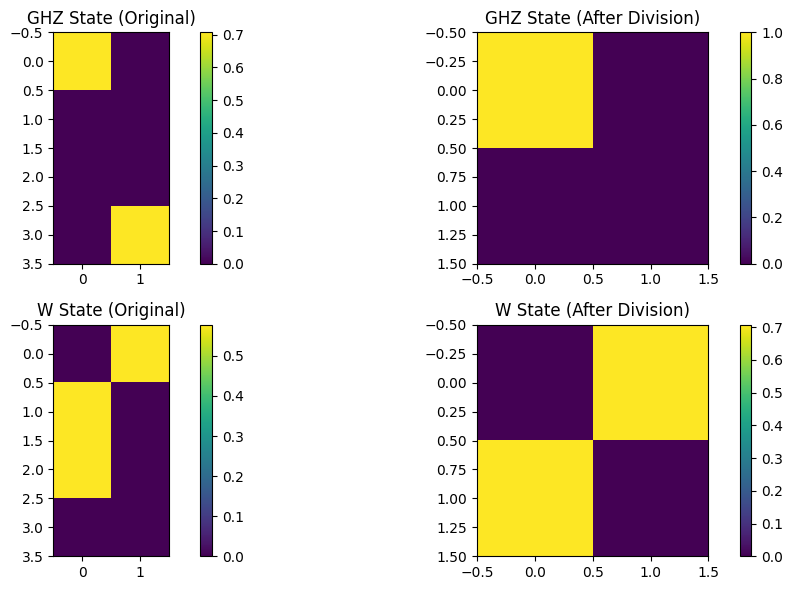

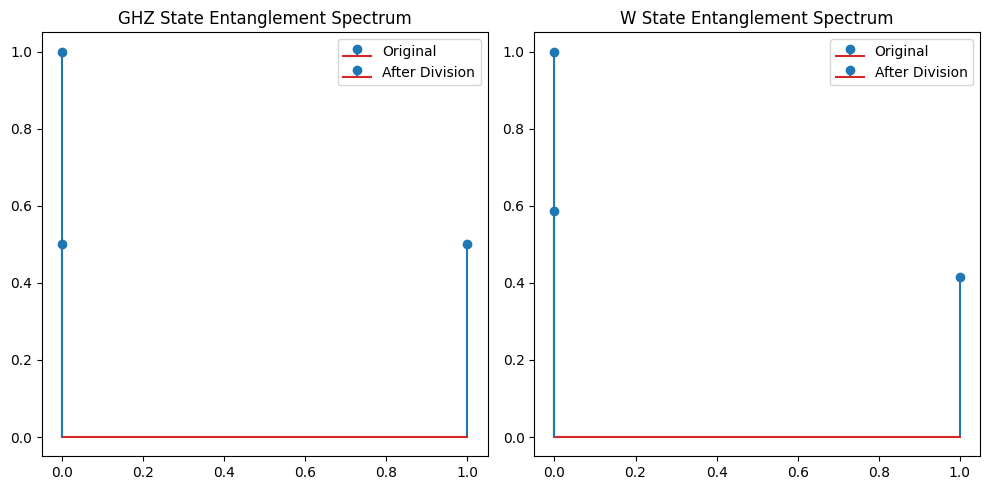

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import logm

def create_ghz_state():
    """Create GHZ state |GHZ⟩ = (|000⟩ + |111⟩)/√2"""
    psi = dbz.zeros((2, 2, 2), dtype=complex)
    psi[0,0,0] = 1/dbz.sqrt(2)
    psi[1,1,1] = 1/dbz.sqrt(2)
    return QuantumTensor(psi)

def create_w_state():
    """Create W state |W⟩ = (|100⟩ + |010⟩ + |001⟩)/√3"""
    psi = dbz.zeros((2, 2, 2), dtype=complex)
    psi[1,0,0] = 1/dbz.sqrt(3)
    psi[0,1,0] = 1/dbz.sqrt(3)
    psi[0,0,1] = 1/dbz.sqrt(3)
    return QuantumTensor(psi)

# Create and analyze states
ghz = create_ghz_state()
w = create_w_state()

# Create zero divisors
complete_zero = QuantumTensor(dbz.zeros((2, 2, 2)))
strategic_zero = QuantumTensor(dbz.ones((2, 2, 2)))
strategic_zero.data[0,0,0] = 0  # Zero at |000⟩

# Perform division
ghz_divided = ghz / complete_zero
w_divided = w / strategic_zero

# Print analysis
print("=== GHZ State Analysis ===")
print("Original shape:", ghz.data.shape)
print("Original data:\n", ghz.data)
print("\nDivided shape:", ghz_divided.data.shape)
print("Divided data:\n", ghz_divided.data)
print("\nEntanglement spectrum before:", ghz._entanglement_spectrum.schmidt_values)
print("Entanglement spectrum after:", ghz_divided._entanglement_spectrum.schmidt_values)

print("\n=== W State Analysis ===")
print("Original shape:", w.data.shape)
print("Original data:\n", w.data)
print("\nDivided shape:", w_divided.data.shape)
print("Divided data:\n", w_divided.data)
print("\nEntanglement spectrum before:", w._entanglement_spectrum.schmidt_values)
print("Entanglement spectrum after:", w_divided._entanglement_spectrum.schmidt_values)

# Save visualizations
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.imshow(dbz.abs(ghz.data.reshape(4, 2)), cmap='viridis')
plt.title("GHZ State (Original)")
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(dbz.abs(ghz_divided.data.reshape(2, 2)), cmap='viridis')
plt.title("GHZ State (After Division)")
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(dbz.abs(w.data.reshape(4, 2)), cmap='viridis')
plt.title("W State (Original)")
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(dbz.abs(w_divided.data.reshape(2, 2)), cmap='viridis')
plt.title("W State (After Division)")
plt.colorbar()

plt.tight_layout()
plt.show()

# Plot entanglement spectra
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.stem(ghz._entanglement_spectrum.schmidt_values, label='Original')
plt.stem(ghz_divided._entanglement_spectrum.schmidt_values, label='After Division')
plt.title("GHZ State Entanglement Spectrum")
plt.legend()

plt.subplot(1, 2, 2)
plt.stem(w._entanglement_spectrum.schmidt_values, label='Original')
plt.stem(w_divided._entanglement_spectrum.schmidt_values, label='After Division')
plt.title("W State Entanglement Spectrum")
plt.legend()

plt.tight_layout()
plt.show()